In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [2]:
# Preprocessing and Utilities
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle

In [3]:
# Clustering algorithms
from sklearn.cluster import KMeans, AffinityPropagation, AgglomerativeClustering
from sklearn_extra.cluster import KMedoids

In [4]:
# Metrics for evaluation
from sklearn.metrics import mean_squared_error
from skimage import color, img_as_float
from skimage.metrics import structural_similarity as ssim

In [5]:
# Carga de imagenes
img_names = ['Bosch','Boticelli','Dali','Monet','Picaso','VanGogh','Velazquez','Vermeer']
path = './Paintings/'

imgs = {}
for i in range(len(img_names)):
    temp = cv2.imread(path+img_names[i]+'.jpg')
    imgs[img_names[i]] = temp

# Función para mostrar imagenes
def show(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")

In [110]:
for i in img_names:
    print(i)

Bosch
Boticelli
Dali
Monet
Picaso
VanGogh
Velazquez
Vermeer


##  Preprocesamiento de Datos

Para poder llevar a cabo la cuantización de colores, se llevará a cabo el siguiente preprocesamiento de los datos: 

**Reducción de Resolución**: Las imagenes, dependiendo de su resolución, pueden estar constituidas por una gran cantidad de píxeles para poder obtener una representación lo más suave, entiendase la dificultad para distinguir los píxeles entre sí, y de mayor calidad posible, lo que en materia de representación resulta muy útil, pero que para el ejercicio presente desarrolla un nuevo reto por el hecho de que una mayor cantidad de pixeles representa una mayor cantidad de valores similares a procesar. Esto, para aquellos algoritmos cuya complejidad espacial se acerque o supere $O(n^2)$, representa un desaf[io debido al alto consumo de memoria en el que se incurre. 

Para poder evitar esta situación, se llevará acabo el proceso de disminución de densidad de las imagenes, para aligerar el costo de procesamiento de los algoritmos y poder evitar o disminuir el consumo de recursos. 

**Flattening o Aplanamiento de la imagen**: Las imagenes son matrices multidimensionales de pixeles pertenecientes a un espacio de color, como puede ser RGB, normalmente en 3D para poder representar cada unode los diferentes colores. Sin embargo, algunos de los algoritmos empleados para cuantizar, como Kmeans o Kmedoids, esperan que se use como datos de entradas características representadas a través de arreglos en 2D, por lo que es necesario que se de un proceso de "aplanmiento" o cambio de forma en el arreglo de pixeles para que puedan emplearse, 


In [6]:
def reduce_res(image,h,w,p=0.8):
    # p es un valor entre 0 y 1, que determina la nueva dimension de la img
    nw = w*p

    nh = h*p
    reduced =  cv2.resize(image, (int(nw), int(nh)), interpolation=cv2.INTER_AREA)
    return (reduced,int(nh),int(nw))

In [ ]:
test = reduce_res(img,img.shape[0],img.shape[1],0.2)
plt.imshow(cv2.cvtColor(test[0], cv2.COLOR_BGR2RGB))
plt.axis("off")

(-0.5, 341.5, 191.5, -0.5)

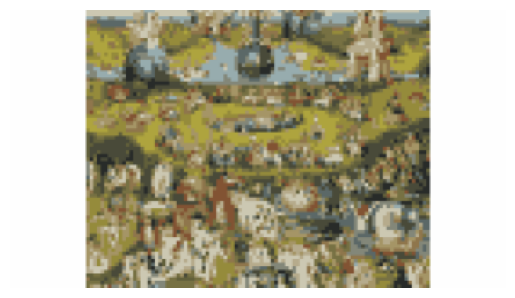

In [105]:
def augment_res(image,h,w,p=0.8):
    # p es un valor entre 0 y 1, que determina la nueva dimension de la img
    nw = w*p

    nh = h*p
    reduced =  cv2.resize(image, (int(nw), int(nh)), interpolation=cv2.INTER_CUBIC)
    return (reduced,int(nh),int(nw))
a = quantizations['hierarchical']['Bosch']['red']
test2 = reduce_res(a,a.shape[0],a.shape[1],2.5)
plt.imshow(cv2.cvtColor(test2[0], cv2.COLOR_BGR2RGB))
plt.axis("off")

In [7]:
# Function to flatten the image
def flatten_img(img,h,w):
    res =  np.reshape(img, ( (h*w),3 ))
    return res

# Function to return the image to its original form
def unflatten_img(img,h,w):
    res = img.reshape((h,w,3))
    return res

In [21]:
def pre_process(img,p=0.8):
    data ={}
    reduced = reduce_res(img,img.shape[0],img.shape[1],p)
    
    data['img'] = reduced[0]
    data['h'] = reduced[1]
    data['w'] = reduced[2]

    data['flat'] = flatten_img(data['img'],data['h'],data['w'])
    return data

def postprocess(clusters,data):
    temp = np.reshape(clusters.astype("uint8")[data['labels']],(data['h'],data['w'], 3))
    return temp

## Cuantización: KMeans

KMeans es un algoritmo de clustering, el cual al hacer el proceso de agrupación divide en k grupos los datos basandosé en la similitud entre ellos. 
Para esto K Means busca minimizar las distancias cuadradas entre cada elemento un su centroide, para luego asignar cada pixel al color más cercano, reduciendo de esta forma la paleta de colores

In [9]:
# definimos la paleta de colores máxima para la cuantización de colores
n_colors = 15
data = {}
n_samples = 1000

Debido a la posible alta cantidad de pixeles que podrían existir aún después de la reducción y dada la naturaleza sensible de K Means a su inicialización, el modelo primero se entrenará primero con un subset de pixeles representativos para poder reducir la carga computacional aún más y facilitar luego el proceso de cuantización completo. 



In [10]:
def sampling(img,n_samples):
    return shuffle(img, random_state=0, n_samples=n_samples)

In [12]:
def kmeans_cuantization(imgs,n_colors,p,n_samples):
    data = {}
    res = {}
    for key,value in imgs.items():
        kmeans = KMeans(n_clusters=n_colors)
        data = pre_process(value,p)
        
        sample = sampling(data['flat'],n_samples)
        kmeans.fit(sample)
        data['labels'] = kmeans.predict(data['flat'])
        
        data['result'] = postprocess(kmeans.cluster_centers_,data)
        
        res[key] = {
            'org':data['img'],
            'red':data['result']
        }
        data = {}

    
    return ('kmeans',res)

(-0.5, 1023.5, 767.5, -0.5)

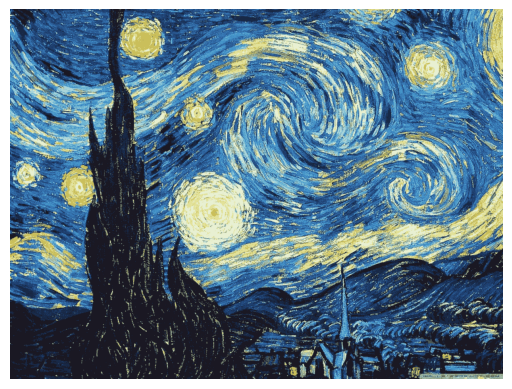

In [412]:
res_img = cv2.cvtColor(data['res'], cv2.COLOR_BGR2RGB)
plt.imshow(res_img)
plt.axis("off")

### Cuantización: KMedoids

In [13]:
def kmedoids_cuantization(imgs,n_colors,p,n_samples):
    data = {}
    res = {}
    for key,value in imgs.items():
        kmedoids = KMedoids(n_clusters=n_colors,method='pam')
        data = pre_process(value,p)
        
        sample = sampling(data['flat'],n_samples)
        kmedoids.fit(sample)
        data['labels'] = kmedoids.predict(data['flat'])
        
        data['result']= postprocess(kmedoids.cluster_centers_,data)
        
        res[key] = {
            'org':data['img'],
            'red':data['result']
        }
        data = {}

    
    return ('kmedoids',res)

(-0.5, 1023.5, 767.5, -0.5)

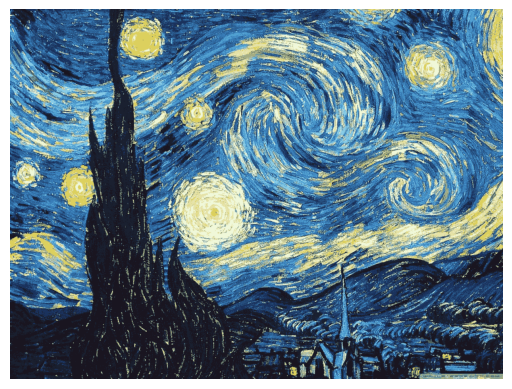

In [406]:
res_img = cv2.cvtColor(data['res'], cv2.COLOR_BGR2RGB)
data = {}
plt.imshow(res_img)
plt.axis("off")

### Cuantización: Hierarchical Clustering

In [512]:
hierarchical = AgglomerativeClustering(n_clusters=n_colors)

In [14]:
def hierarchical_cuantization(imgs,n_colors,p,n_samples):
    data = {}
    res = {}
    for key,value in imgs.items():
        hierarchical = AgglomerativeClustering(n_clusters=n_colors)
        data = pre_process(value,p)
        data['labels'] =hierarchical.fit_predict(data['flat'])
        
        cluster_centers = np.array([data['flat'][data['labels'] == i].mean(axis=0) for i in range(n_colors)])
        data['result']= postprocess(cluster_centers,data)
        
        res[key] = {
            'org':data['img'],
            'red':data['result']
        }
        data = {}

    
    return ('hierarchical',res)

(-0.5, 114.5, 85.5, -0.5)

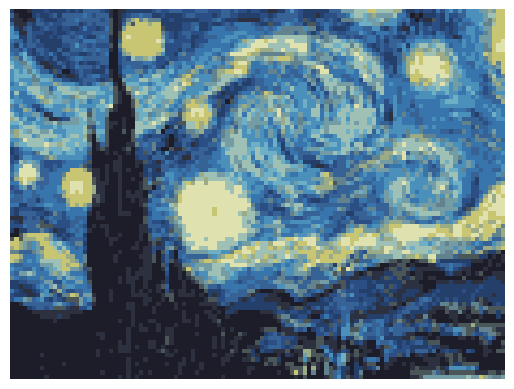

In [398]:
res_img = cv2.cvtColor(data['res'], cv2.COLOR_BGR2RGB)
data = {}
plt.imshow(res_img)
plt.axis("off")

## Evaluación de Resultados

Para evaluar los resultados de los algoritmos usados para la cunatización, se usarán 3 medidas, dos cuantitivas (MSE, SSIM) y una cualitativa (Delta-E). A continuación se brinda una breve explicación de cada una de ellas y el porqué de su uso: 

* MSE: Medida cuantitativa, la cual devolverá el la diferencia del promedio cuadrada de los pixeles entre ambas imágenes, evaluando de esta forma la diferencia entre los valores de los pixeles de ambas imágenes. Al ser meramente cuantitativa y basandosé solamente en similitudes, sus resultados pueden indicar que imágenes que no son tan similares al ojo humano son más similares a un nivel mátematico.
  
* SSIM: Es una medida cuantitativa conceptual, la cual evalúa los cambios y diferencias en contraste, ilumniación e información estructural, para modelar la forma en que precibimos las imágenes y su calidad, para dar una medición más robusta que MSE.

  
* Delta-E: Es una medida más cualitativa que las anteriores, ya que mide la de percepción entre dos colores en un espacio uniforme de color. En este caso, se usará el espacio de color CIELAB, que se diseño para aproximarse a la forma de visión humana y fuciona de la siguiente manera: *L* representa el grado de brillo de una imagen. en un rango de 0 a 100; *a* es el eje rojo-verde, donde valores positivos indican un mayor tono rojizo y valores negativos uno verde; *b* un indice azul-amarillo, siendo valores positivos más cercanos al amarillo y negativos al azul.



In [15]:
def delta_e(original, reduced):
    # Convert images to LAB color space
    lab_original = color.rgb2lab(original)
    lab_reduced = color.rgb2lab(reduced)
    
    # Compute the Delta-E (color difference)
    delta_e = color.deltaE_cie76(lab_original, lab_reduced)
    return np.mean(delta_e)  # Average color difference


In [16]:
def metrics(original,reduced):
    res = {}
    f_org= img_as_float(original)
    f_res = img_as_float(reduced)
    res['MSE'] = mean_squared_error(original.flatten(), reduced.flatten())
    res['SSIM'] = ssim(f_org, f_res, full=True, multichannel=True,channel_axis=2,data_range=f_res.max()-f_res.min())[0]
    res['Delta-E'] = delta_e(original,reduced)
    return res
    

In [17]:
def calculate_metrics(results):
    for key,value in results.items():
        results[key]['metrics'] =  metrics(results[key]['org'],results[key]['red'])
    return 

In [18]:
def show_result(original,reduced,metrics):
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.imshow(cv2.cvtColor(reduced, cv2.COLOR_BGR2RGB))
    print(f" Resultado de MSE: {metrics['MSE']} \n Resultado de SSIM:{metrics['SSIM']} \n Resultado Delta-E: {metrics['Delta-E']}")

In [22]:
quantizations = {}

temp = kmeans_cuantization(imgs,n_colors,0.8,n_samples)
calculate_metrics(temp[1])
quantizations[temp[0]] = temp[1]


In [23]:
temp = kmedoids_cuantization(imgs,n_colors,0.4,n_samples)
calculate_metrics(temp[1])
quantizations[temp[0]] = temp[1]

In [24]:
temp = hierarchical_cuantization(imgs,n_colors,0.1,n_samples)
calculate_metrics(temp[1])
quantizations[temp[0]] = temp[1]

In [ ]:
def gallery(q,names,extended=False):
    methods = ['kmeans', 'kmedoids', 'hierarchical']
    titles = ['Original', 'KMeans', 'KMedoids', 'Hierarchical']
    rows = len(names)

    if extended:
        rows = 2*len(names)
    fig, axs = plt.subplots(nrows=rows, ncols=4, figsize=(15,3))  # Adjusted figsize
    j = 0
    for i in names:
        axs[j,0].imshow(cv2.cvtColor(quantizations['kmeans'][i]['org'], cv2.COLOR_BGR2RGB))
        axs[j,1].imshow(cv2.cvtColor(quantizations['kmeans'][i]['red'], cv2.COLOR_BGR2RGB))
        axs[j,2].imshow(cv2.cvtColor(quantizations['kmedoids'][i]['red'], cv2.COLOR_BGR2RGB))
        axs[j,3].imshow(cv2.cvtColor(quantizations['hierarchical'][i]['red'], cv2.COLOR_BGR2RGB))
        if extended:
            for k in range(1,4):
                j += 1
                mse = quantizations[methods[k]][i]['metrics']['MSE']
                ss = quantizations[methods[k]][i]['metrics']['SSIM']
                delta_e = quantizations[methods[k]][i]['metrics']['Delta-E']

                # Add title for each method
                axs[j,k].set_title(titles[k], fontsize=16)
            
                # Add text below each image (inside the plot)
                axs[j,k].text(0.5, 0.01, f'MSE: {mse:.2f}\nSSIM: {ss:.2f}\nΔE: {delta_e:.2f}',
                               fontsize=12,ha="center")
            
        j += 1

    

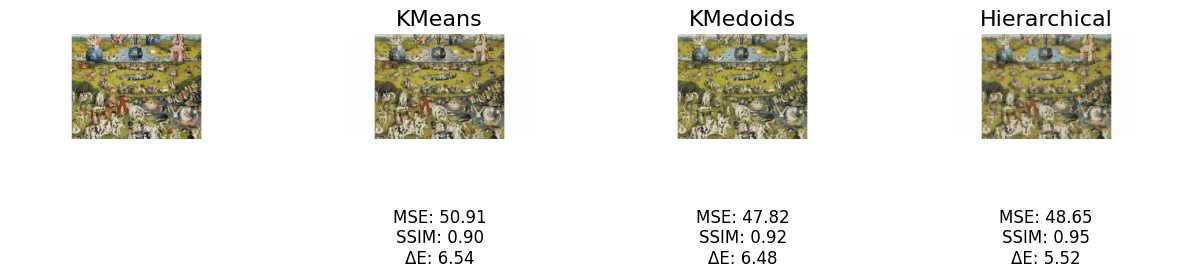

In [93]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,3))  # Adjusted figsize



# Plot the images
axs[0,0].imshow(cv2.cvtColor(quantizations['kmeans']['Bosch']['org'], cv2.COLOR_BGR2RGB))
axs[0,1].imshow(cv2.cvtColor(quantizations['kmeans']['Bosch']['red'], cv2.COLOR_BGR2RGB))
axs[0,2].imshow(cv2.cvtColor(quantizations['kmedoids']['Bosch']['red'], cv2.COLOR_BGR2RGB))
axs[0,3].imshow(cv2.cvtColor(quantizations['hierarchical']['Bosch']['red'], cv2.COLOR_BGR2RGB))


# Add metrics below each image
methods = ['kmeans', 'kmeans', 'kmedoids', 'hierarchical']
titles = ['Original', 'KMeans', 'KMedoids', 'Hierarchical']

for i in range(1,4):
    mse = quantizations[methods[i]]['Bosch']['metrics']['MSE']
    ss = quantizations[methods[i]]['Bosch']['metrics']['SSIM']
    delta_e = quantizations[methods[i]]['Bosch']['metrics']['Delta-E']

    # Add title for each method
    axs[0,i].set_title(titles[i], fontsize=16)

    # Add text below each image (inside the plot)
    axs[1,i].text(0.5, 0.01, f'MSE: {mse:.2f}\nSSIM: {ss:.2f}\nΔE: {delta_e:.2f}',
                   fontsize=12,ha="center")

# Hide the axes for the second row (since it's only for the text)
for ax in axs[1, :]:
    ax.axis('off')

# Hide axes for the first row images
for ax in axs[0]:
    ax.axis('off')
# Adjust the space between the plots


# Optionally use tight_layout() with padding adjustments

plt.show()

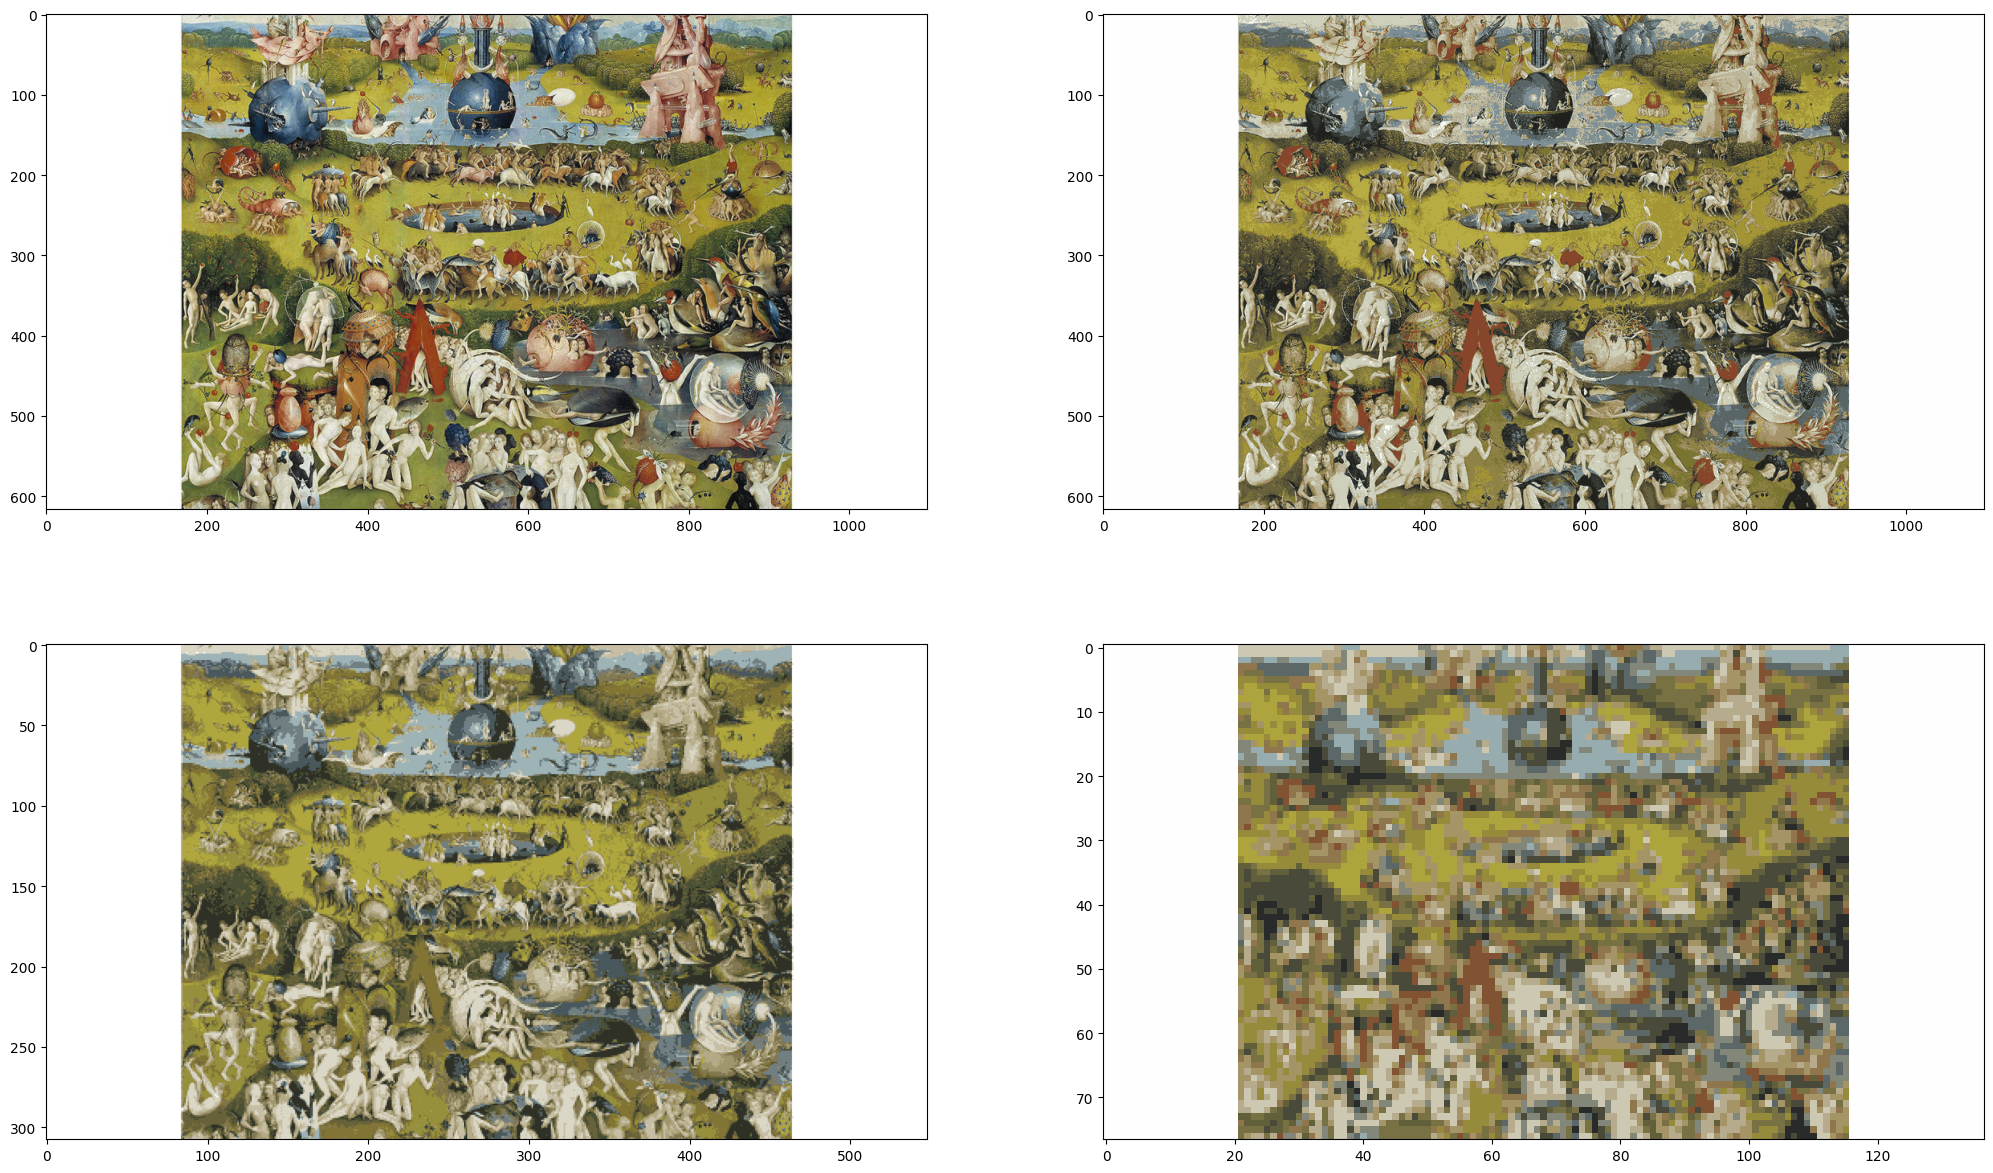

In [99]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(25,15))


# Plot the images
axs[0,0].imshow(cv2.cvtColor(quantizations['kmeans']['Bosch']['org'], cv2.COLOR_BGR2RGB))
axs[0,1].imshow(cv2.cvtColor(quantizations['kmeans']['Bosch']['red'], cv2.COLOR_BGR2RGB))
axs[1,0].imshow(cv2.cvtColor(quantizations['kmedoids']['Bosch']['red'], cv2.COLOR_BGR2RGB))
axs[1,1].imshow(cv2.cvtColor(quantizations['hierarchical']['Bosch']['red'], cv2.COLOR_BGR2RGB))


plt.show()

Contestar las siguientes preguntas:

1. ¿Esta a gusto con la cuantización realizada?
     De manera general sí, pues se retiene de forma bastante decente la idea original de la imagen, pudiendo representarse con un menor número de colores. Personalmente, la representación mediante kmeans, de los algoritmos utilizados es con la que más agusto me encuentro, pues en ciertos casos como 'La noche estrellada' de Van Gogh o 'Las señoritas de Aviñón' de Picaso, las reducciones fueron bastante buenas para la limitante de 15 clusters y sin presentar demasiadas complicaciones para entrenar el modelo. Y aunque se pierden algunos colores en los procesos, la imagen se mantiene con una paleta de colores que difiere al ojo humano más en detalles especifícos que en grandes elementos que podrían distorsionar su percepción. 
   
2. ¿Cómo puede mejorar los resultados?
    Para mejorar los resultados, habría que empezar desde el preprocesamiento, mediante la reducción de elementos muy repetidos para poder reducir los efectos de la sobre-representación de algunos colores y tratar de conservar algunos de los menos representados para que al momento de hacer el clustering, los valores se mantengan o sean más cercanos y similares disminuyendo la pérdida de tonalidades y expresividad en comparación con la original.

   También, la optimización de algunos algoritmos para poder reducir el tamaño en memoría empleado y en algunos casos el costo temporal, como en los casos de kmedoids y Clustering Jerárquico para que puedan trabajar con datasets o imágenes más grandes, reduciendo de esta forma los costos computacionales que si bien en este proyecto son meramente en materia de tiempo, en el mundo real estos se traducen en forma de costos monetarios o un mayor nivel de dificultad de implementación para poder ajustar los datos a párametros más razonables de usarse estos algoritmos.

   Por último, de no poderse el apartado anterior, utilizar algoritmos los cuales escalen mejor en eficiencia respecto al tamaño del dataset, para que al utilizar menos recursos que los anteriores, se pueden buscar resultados aún más precisos y con menos costos al momento de usarlos. 

   
3. Describa brevemente que han hecho los algoritmos de clustering y sus diferencias. Puede usar figuras, gráficas, etc para complementar esta respuesta.


4. ¿Qué problemas tuvo a la hora de realizar esta parte del proyecto?
       Uno de los mayores inconvenientes al momento de realizar esta parte del proyecto, fue la gran cantidad de elementos que componen las imagénes y el nivel de complejidad espacial de algunos algoritmos considerados como Clustering Jerárquico o Kmedoids, con un costo de $O(n^2)$, y que sus implementaciones en las líbrerias no eran las más eficientes en este aspecto; lo que generaba un alto consumo de memoria de almacenamiento que en muchos casos sobrepasaba la poseída por el ordenador, impidiendo realizar la cuantización.
   Esto obligó a que se buscasen métodos para reducir la cantidad de píxeles que componian la imagen, pero al mismo tiempo tratando de mantener la calidad y la fidelidad lo más cercana posible a la original , ya que de no ser así, podrían perderse ciertos colores que no estuviesen muy representados en la imagen o reducir demasiado su representación, lo que se propagaba al momento de cuantizar donde dichos colores se perdían definitivamente.

   Esto también señala de forma tangencial otro de los problemas y era la sobre-representación de algunos colores y la sub-representación de otros, lo que daba lugar a que en ciertas pinturas, al momento de cuantizarlas, los pixeles subrepresentados tendían a desaparecer de las paletas generadas por los algoritmos de clustering y en ciertos casos los colores más dominantes o que se superponían a los demás terminaban siendo los sobre-representados, llegando a aparecer en lugares que no estaban antes a manera de substituto de los que desaparecieron. 